## Problem 1: Geocode shopping centers (5 points)

The aim of problems 1-3 is to find out **how many people live within a walking distance (1.5 km) from selected shopping centers in Helsinki**.

In problem 1 the task is to find out the addresses for a list of shopping centers and to geocode these addresses in order to represent them as points. The output should be stored in a Shapefile called `shopping_centers.shp` 

**Preparation:** Find out the addresses for following shopping centers from the internet, and write the addresses into a text file called `shopping_centers.txt`:

 - Itis
 - Forum
 - Iso-omena
 - Sello
 - Jumbo
 - REDI
 - Mall of Tripla 
 

`shopping_centers.txt` should have semicolon (`;`) as a separator, and the file should include the following columns:

- ``id`` (integer) containing an unique identifier for each shopping center
- ``name`` (string) of each shopping center
- ``addr`` (string) the address 


See and example of how to format the text file [in the lesson 3 materials](https://autogis-site.readthedocs.io/en/latest/notebooks/L3/geocoding_in_geopandas.html). Save (and upload) the text file into your exercise repository.

- Read `shopping_centers.txt` that you just created into a pandas DataFrame called ``data``:

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import geojson
from pyproj import CRS
from shapely.geometry import Point
from geopandas.tools import geocode

# Read the data 
fp = r"shopping_centers.txt"
data = pd.read_csv(fp, sep=';')

In [2]:
#NON-EDITABLE TEST CELL
# Check your input data
print(data)

     id            name                                            addr
0  1000            Itis            Itäkatu 1-7, 00930 Helsinki, Finland
1  1001           Forum  Mannerheimintie 14–20, 00100 Helsinki, Finland
2  1002       Iso-omena           Piispansilta 11, 02230 Espoo, Finland
3  1003           Sello       Leppävaarankatu 3-9, 02600 Espoo, Finland
4  1004           Jumbo      Vantaanportinkatu 3, 01510 Vantaa, Finland
5  1005            Redi   Hermannin rantatie 5, 00580 Helsinki, Finland
6  1006  Mall of Tripla      Fredikanterassi 1, 00520 Helsinki, Finland


- Geocode the addresses using the Nominatim geocoding service. Store the output in a variable called `geo`:

In [1]:
# Geocode the addresses using Nominatim
geo = geocode(data['addr'], provider='nominatim', user_agent='Gregg_Autogis', timeout=4)
mall_of_tripla = Point(24.930262169736544, 60.198500308207706)
print(mall_of_tripla)
geo.loc[6,'geometry'] = mall_of_tripla

In [4]:
#NON-EDITABLE TEST CELL
# Check the geocoded output
print(geo)

                    geometry  \
0  POINT (25.08294 60.21170)   
1  POINT (24.93828 60.16878)   
2  POINT (24.73810 60.16024)   
3  POINT (24.81042 60.21752)   
4  POINT (24.96282 60.29245)   
5  POINT (24.97904 60.18702)   
6  POINT (24.93026 60.19850)   

                                             address  
0  Kauppakeskus Itis, 1-7, Itäkatu, Itäkeskus, Va...  
1  Salaattiasema, 14-20, Mannerheimintie, Keskust...  
2  Captain Corvus, 11, Piispansilta, Matinkylän k...  
3  Lasten kappeli Arkki, 3-9, Leppävaarankatu, Sä...  
4  Stockmann, 3, Vantaanportinkatu, Vantaanportti...  
5  Silta, 5, Hermannin rantatie, Verkkosaari, Kal...  
6                                               None  


In [5]:
#NON-EDITABLE TEST CELL
# Check the data type (should be a GeoDataFrame!)
print(type(geo))

<class 'geopandas.geodataframe.GeoDataFrame'>


Check that the coordinate reference system of the geocoded result is correctly defined, and **reproject the layer into ETRS GK-25** (EPSG:3879):

In [6]:
geo = geo.to_crs(epsg=3879)

In [7]:
#NON-EDITABLE TEST CELL
# Check layer crs
print(geo.crs)

epsg:3879


- Make a table join between the geocoded addresses (``geo``) and the original addresses (``data``) in order to link the numerical coordinates and  the `id` and `name` of each shopping center. 
- Store the output in a variable called ``geodata`` 


In [8]:
# Join the tables
geodata = geo.join(data)

In [9]:
#NON-EDITABLE TEST CELL
# Check the join output
print(geodata.head())

                           geometry  \
0  POINT (25504598.602 6677662.109)   
1  POINT (25496573.542 6672878.360)   
2  POINT (25485456.867 6671954.184)   
3  POINT (25489491.076 6678322.265)   
4  POINT (25497943.932 6686656.982)   

                                             address    id       name  \
0  Kauppakeskus Itis, 1-7, Itäkatu, Itäkeskus, Va...  1000       Itis   
1  Salaattiasema, 14-20, Mannerheimintie, Keskust...  1001      Forum   
2  Captain Corvus, 11, Piispansilta, Matinkylän k...  1002  Iso-omena   
3  Lasten kappeli Arkki, 3-9, Leppävaarankatu, Sä...  1003      Sello   
4  Stockmann, 3, Vantaanportinkatu, Vantaanportti...  1004      Jumbo   

                                             addr  
0            Itäkatu 1-7, 00930 Helsinki, Finland  
1  Mannerheimintie 14–20, 00100 Helsinki, Finland  
2           Piispansilta 11, 02230 Espoo, Finland  
3       Leppävaarankatu 3-9, 02600 Espoo, Finland  
4      Vantaanportinkatu 3, 01510 Vantaa, Finland  


- Save the output as a Shapefile called `shopping_centers.shp` 

In [10]:
# Define output filepath
out_fp = "shopping_centers.shp"

# Save file
geodata.to_file(out_fp)

In [11]:
#NON-EDITABLE TEST CELL
# Print info about output file
print("Geocoded output is stored in this file:", out_fp)

Geocoded output is stored in this file: shopping_centers.shp


## Problem 2: Create buffers around shopping centers (5 points)

Let's continue with our case study and calculate a 1.5 km buffer around the geocoded points. 


- Start by creating a new column called `buffer` to ``geodata`` GeoDataFrame:

In [12]:
geodata['buffer'] = 0

- Calculate a 1.5 km buffer for each geocoded point. Store the buffer geometry in the new `buffer` column.

Here, you can use the [GeoDataFrame buffer() method](http://geopandas.org/geometric_manipulations.html#GeoSeries.buffer), which uses Shapely's [buffer](http://toblerity.org/shapely/manual.html#object.buffer) in the bacground. You only need to use the `distance` -parameter, don't worry about the other parameters.

In [13]:
geodata['buffer'] = geodata['geometry'].buffer(1500)

In [14]:
#NON-EDITABLE TEST CELL
print(geodata.head())

                           geometry  \
0  POINT (25504598.602 6677662.109)   
1  POINT (25496573.542 6672878.360)   
2  POINT (25485456.867 6671954.184)   
3  POINT (25489491.076 6678322.265)   
4  POINT (25497943.932 6686656.982)   

                                             address    id       name  \
0  Kauppakeskus Itis, 1-7, Itäkatu, Itäkeskus, Va...  1000       Itis   
1  Salaattiasema, 14-20, Mannerheimintie, Keskust...  1001      Forum   
2  Captain Corvus, 11, Piispansilta, Matinkylän k...  1002  Iso-omena   
3  Lasten kappeli Arkki, 3-9, Leppävaarankatu, Sä...  1003      Sello   
4  Stockmann, 3, Vantaanportinkatu, Vantaanportti...  1004      Jumbo   

                                             addr  \
0            Itäkatu 1-7, 00930 Helsinki, Finland   
1  Mannerheimintie 14–20, 00100 Helsinki, Finland   
2           Piispansilta 11, 02230 Espoo, Finland   
3       Leppävaarankatu 3-9, 02600 Espoo, Finland   
4      Vantaanportinkatu 3, 01510 Vantaa, Finland   

       

In [15]:
#NON-EDITABLE TEST CELL
# Check the data type of the first value in the buffer-column
print(type(geodata.at[0,'buffer']))

<class 'shapely.geometry.polygon.Polygon'>


In [16]:
#NON-EDITABLE TEST CELL
# Check the areas of your buffers in km^2
print(round(gpd.GeoSeries(geodata["buffer"]).area / 1000000))

0    7.0
1    7.0
2    7.0
3    7.0
4    7.0
5    7.0
6    7.0
dtype: float64


- Replace the values in `geometry` column with the values of `buffer` column:

In [17]:
geodata['geometry'] = geodata['buffer']

In [18]:
#NON-EDITABLE TEST CELL
print(geodata.head())

                                            geometry  \
0  POLYGON ((25506098.602 6677662.109, 25506091.3...   
1  POLYGON ((25498073.542 6672878.360, 25498066.3...   
2  POLYGON ((25486956.867 6671954.184, 25486949.6...   
3  POLYGON ((25490991.076 6678322.265, 25490983.8...   
4  POLYGON ((25499443.932 6686656.982, 25499436.7...   

                                             address    id       name  \
0  Kauppakeskus Itis, 1-7, Itäkatu, Itäkeskus, Va...  1000       Itis   
1  Salaattiasema, 14-20, Mannerheimintie, Keskust...  1001      Forum   
2  Captain Corvus, 11, Piispansilta, Matinkylän k...  1002  Iso-omena   
3  Lasten kappeli Arkki, 3-9, Leppävaarankatu, Sä...  1003      Sello   
4  Stockmann, 3, Vantaanportinkatu, Vantaanportti...  1004      Jumbo   

                                             addr  \
0            Itäkatu 1-7, 00930 Helsinki, Finland   
1  Mannerheimintie 14–20, 00100 Helsinki, Finland   
2           Piispansilta 11, 02230 Espoo, Finland   
3       Lepp

Optional: at this point, you can drop out unnecessary columns from the geodataframe. In the next problem, 
we will only need these columns: `'id', 'name', 'geometry'`

In [19]:
geodata = geodata.drop(['address', 'addr', 'buffer'], axis=1)

In [20]:
geodata.head()

,geometry,id,name
0,"POLYGON ((25506098.602 6677662.109, 25506091.3...",1000,Itis
1,"POLYGON ((25498073.542 6672878.360, 25498066.3...",1001,Forum
2,"POLYGON ((25486956.867 6671954.184, 25486949.6...",1002,Iso-omena
3,"POLYGON ((25490991.076 6678322.265, 25490983.8...",1003,Sello
4,"POLYGON ((25499443.932 6686656.982, 25499436.7...",1004,Jumbo


## Problem 3: How many people live near shopping centers? (5 points)

Last step in our analysis is to make a spatial join between our buffer layer and population data in order to find out **how many people live near each shopping center**. We will use the same data as we did during [lesson 3](https://automating-gis-processes.github.io/site/notebooks/L3/spatial-join.html#Spatial-join); **a Population Grid** that is available via the HSY wfs. 

Alternatively, you can also download the data from the [Helsinki Region Infoshare (HRI)](https://hri.fi/data/en_GB/dataset/vaestotietoruudukko) on your computer and read it in using geopandas.

The coordinate reference system of the population grid is **ETRS GK-25 (EPSG:3879)**.


**Steps:**

- Read the population grid into a geodataframe

- Select only the useful columns from the population grid: ``'asukkaita'`` (=population count per grid square) and ``'geometry'`` 

- Make a spatial join between your buffered point layer and population grid layer. Join the information now from buffer layer **into the population grid layer**

- Group the joined layer by shopping center index

- Calculate the sum of population living within 1.5 km for each shopping center.

**Finally:**

- Print out the population living within 1.5 km from each shopping center:

     - Itis
     - Forum
     - Iso-omena
     - Sello
     - Jumbo
     - REDI
     - Mall of Tripla
     
**Final print out should contain both the shopping center name and population count**, for example: `25858 people live within 1.5 km from Iso-Omena`.

*Feel free to divide your solution into several codeblocks! Remember to comment your code  :)*

In [21]:
# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format).
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018',
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))


In [22]:
pop = pop.rename(columns={'asukkaita': 'pop18'})
pop = pop[["pop18", "geometry"]]
pop.head()

,pop18,geometry
0,108,MULTIPOLYGON Z (((25476499.999 6674248.999 0.0...
1,273,MULTIPOLYGON Z (((25476749.997 6674498.998 0.0...
2,239,MULTIPOLYGON Z (((25476999.994 6675749.004 0.0...
3,202,MULTIPOLYGON Z (((25476999.994 6675499.004 0.0...
4,261,MULTIPOLYGON Z (((25476999.994 6675249.005 0.0...


In [23]:
# Read population grid data for 2018 into a variable `pop`. 
# Remember to check the crs info! 

pop.crs = CRS.from_epsg(3879)
geodata.crs
pop.crs == geodata.crs

True

In [24]:
#NON-EDITABLE TEST CELL
# Check your input data
print("Number of rows:", len(pop))
print(pop.head(3))

Number of rows: 3167
   pop18                                           geometry
0    108  MULTIPOLYGON Z (((25476499.999 6674248.999 0.0...
1    273  MULTIPOLYGON Z (((25476749.997 6674498.998 0.0...
2    239  MULTIPOLYGON Z (((25476999.994 6675749.004 0.0...


In [25]:
# Create a spatial join between grid layer and buffer layer. 

join = gpd.sjoin(pop, geodata, how="inner", op="within")
join.head()

,pop18,geometry,index_right,id,name
404,116,MULTIPOLYGON Z (((25484250.000 6672499.005 0.0...,2,1002,Iso-omena
423,114,MULTIPOLYGON Z (((25484499.998 6672749.004 0.0...,2,1002,Iso-omena
424,128,MULTIPOLYGON Z (((25484499.998 6672499.005 0.0...,2,1002,Iso-omena
425,241,MULTIPOLYGON Z (((25484499.998 6671998.997 0.0...,2,1002,Iso-omena
426,305,MULTIPOLYGON Z (((25484499.998 6671748.997 0.0...,2,1002,Iso-omena


<AxesSubplot:>

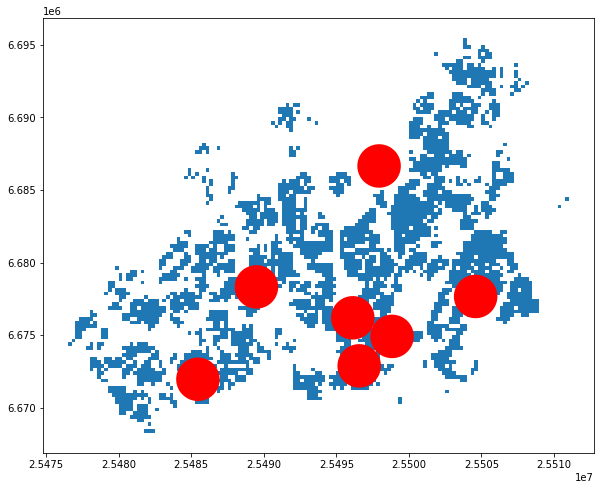

In [26]:
fig, ax = plt.subplots(figsize=(15,8))

# Plot population grid
pop.plot(ax=ax)

# Plot points
geodata.plot(ax=ax, color='red', markersize=5)

In [54]:
grouped = join.groupby("index_right")
print(len(grouped) == join["index_right"].nunique())
grouped.get_group(1)

True


,pop18,geometry,index_right,id,name
1513,468,MULTIPOLYGON Z (((25495249.995 6673249.002 0.0...,1,1001,Forum
1514,515,MULTIPOLYGON Z (((25495249.995 6672249.006 0.0...,1,1001,Forum
1543,2123,MULTIPOLYGON Z (((25495499.993 6673499.001 0.0...,1,1001,Forum
1544,1955,MULTIPOLYGON Z (((25495499.993 6673249.002 0.0...,1,1001,Forum
1545,807,MULTIPOLYGON Z (((25495499.993 6672999.003 0.0...,1,1001,Forum
...,...,...,...,...,...
1810,1759,MULTIPOLYGON Z (((25497499.999 6673499.001 0.0...,1,1001,Forum
1811,1875,MULTIPOLYGON Z (((25497499.999 6673249.002 0.0...,1,1001,Forum
1812,1167,MULTIPOLYGON Z (((25497499.999 6672999.003 0.0...,1,1001,Forum
1848,207,MULTIPOLYGON Z (((25497749.996 6672999.003 0.0...,1,1001,Forum


In [50]:
# Report how many people live within 1.5 km distance from each shopping center

for key, group in grouped:
    shopping_center = group.iat[1,4]
    pop_sum = group['pop18'].sum()
    print("{} people live within 1.5km from {}".format(pop_sum, shopping_center))

19930 people live within 1.5km from Itis
56394 people live within 1.5km from Forum
25976 people live within 1.5km from Iso-omena
20191 people live within 1.5km from Sello
10317 people live within 1.5km from Jumbo
24540 people live within 1.5km from Redi
23421 people live within 1.5km from Mall of Tripla


**Reflections:**
    
- How challenging did you find problems 1-3 (on scale to 1-5), and why?
- What was easy?
- What was difficult?

YOUR ANSWER HERE

Well done! Now you can continue to [problem 4](Exercise-3-Problem-4.ipynb)